<a href="https://colab.research.google.com/github/lielorenstein/Sparkle/blob/main/Cars_with_accuracy_Mask_R_CNN_Image_Segmentation_Demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Mask R-CNN Image Segmentation Demo
This Colab enables you to use a Mask R-CNN model that was trained on Cloud TPU to perform instance segmentation on a sample input image. The resulting predictions are overlayed on the sample image as boxes, instance masks, and labels. You can also experiment with your own images by editing the input image URL.

### About Mask R-CNN
The Mask R-CNN model addresses one of the most difficult computer vision challenges: image segmentation. Image segmentation is the task of detecting and distinguishing multiple objects within a single image. In particular, Mask R-CNN performs "instance segmentation," which means that different instances of the same type of object in the input image, for example, car, should be assigned distinct labels.

# Instructions
<h3><a href="https://cloud.google.com/tpu/"><img valign="middle" src="https://raw.githubusercontent.com/GoogleCloudPlatform/tensorflow-without-a-phd/master/tensorflow-rl-pong/images/tpu-hexagon.png" width="50"></a>  &nbsp;&nbsp;Use a free Cloud TPU</h3>
 
   1. On the main menu, click Runtime and select **Change runtime type**. Set "TPU" as the hardware accelerator.
   2. Click Runtime again and select **Runtime > Run All**. You can also run the cells manually with Shift-ENTER.

## Download the source code
Download the source code of the Mask R-CNN model.

In [198]:
!git clone https://github.com/tensorflow/tpu/

fatal: destination path 'tpu' already exists and is not an empty directory.


## Import libraries

In [199]:
from IPython import display
from PIL import Image
import numpy as np
%tensorflow_version 1.x
import tensorflow as tf
import sys
sys.path.insert(0, 'tpu/models/official')
sys.path.insert(0, 'tpu/models/official/mask_rcnn')
import coco_metric
from mask_rcnn.object_detection import visualization_utils

## Load the COCO index mapping
This Colab uses a pretrained checkpoint of the Mask R-CNN model that is trained using the COCO dataset. Here is the mapping between the indices that the model predicts and the categories in text.

In [200]:
'''
ID_MAPPING = {
    1: 'person',
    2: 'bicycle',
    3: 'car',
    4: 'motorcycle',
    5: 'airplane',
    6: 'bus',
    7: 'train',
    8: 'truck',
    9: 'boat',
    10: 'traffic light',
    11: 'fire hydrant',
    13: 'stop sign',
    14: 'parking meter',
    15: 'bench',
    16: 'bird',
    17: 'cat',
    18: 'dog',
    19: 'horse',
    20: 'sheep',
    21: 'cow',
    22: 'elephant',
    23: 'bear',
    24: 'zebra',
    25: 'giraffe',
    27: 'backpack',
    28: 'umbrella',
    31: 'handbag',
    32: 'tie',
    33: 'suitcase',
    34: 'frisbee',
    35: 'skis',
    36: 'snowboard',
    37: 'sports ball',
    38: 'kite',
    39: 'baseball bat',
    40: 'baseball glove',
    41: 'skateboard',
    42: 'surfboard',
    43: 'tennis racket',
    44: 'bottle',
    46: 'wine glass',
    47: 'cup',
    48: 'fork',
    49: 'knife',
    50: 'spoon',
    51: 'bowl',
    52: 'banana',
    53: 'apple',
    54: 'sandwich',
    55: 'orange',
    56: 'broccoli',
    57: 'carrot',
    58: 'hot dog',
    59: 'pizza',
    60: 'donut',
    61: 'cake',
    62: 'chair',
    63: 'couch',
    64: 'potted plant',
    65: 'bed',
    67: 'dining table',
    70: 'toilet',
    72: 'tv',
    73: 'laptop',
    74: 'mouse',
    75: 'remote',
    76: 'keyboard',
    77: 'cell phone',
    78: 'microwave',
    79: 'oven',
    80: 'toaster',
    81: 'sink',
    82: 'refrigerator',
    84: 'book',
    85: 'clock',
    86: 'vase',
    87: 'scissors',
    88: 'teddy bear',
    89: 'hair drier',
    90: 'toothbrush',
}
'''

ID_MAPPING = {
    1: 'person',
    2: 'bicycle',
    3: 'car',
}

category_index = {k: {'id': k, 'name': ID_MAPPING[k]} for k in ID_MAPPING}

## Load an image
Now, you can load an image. Use either the sample image included here, or update the field with an image of your choice.

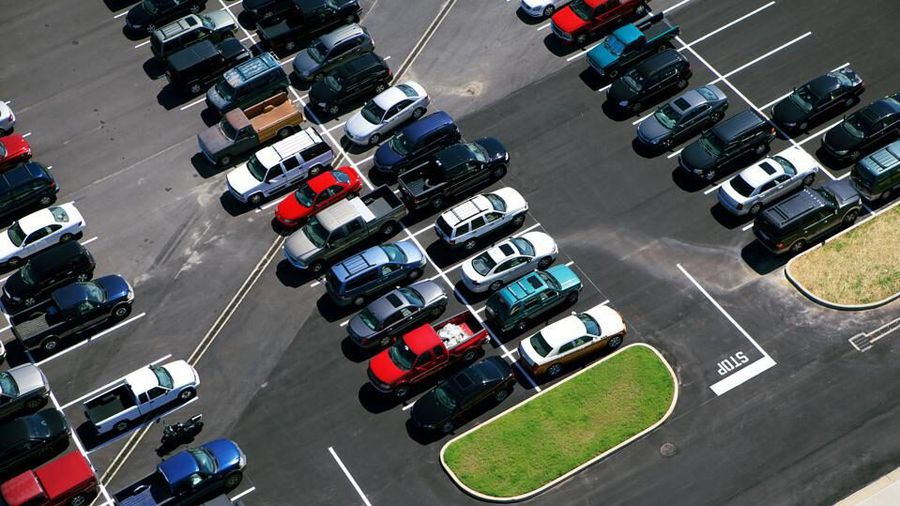

In [201]:
#!wget https://thumbor.forbes.com/thumbor/fit-in/900x510/https://www.forbes.com/advisor/wp-content/uploads/2020/10/parking-lot-e1603271819709.jpg -O p1.jpg
#!wget https://www.peakefowler.com/wp-content/uploads/2019/10/parking-lot-accident-700x321.jpg -O p2.jpg
#!wget https://thephiladelphiacitizen.org/wp-content/uploads/2019/09/parking-in-philadelphia.jpg -O p3.jpg
#!wget https://www.abbynews.com/wp-content/uploads/2019/11/19586807_web1_parking-lot-684160_1920.jpg -O p4.jpg
#!wget https://dz5vhvq2e26ss.cloudfront.net/media/image/7595667854e9da321.01809399.jpg -O p5.jpg
#!wget https://www.yesterland.com/images-mainstreet/parkinglot_withhotel1976mc.jpg -O p6.jpg
#!wget https://assets.newatlas.com/dims4/default/234ea16/2147483647/strip/true/crop/1610x1080+0+0/resize/1431x960!/quality/90/?url=http%3A%2F%2Fnewatlas-brightspot.s3.amazonaws.com%2Farchive%2Fautonomous-car-parking-2.jpg -O p7.jpg
#!wget https://parquery.com/media/filer_public_thumbnails/filer_public/60/17/60179ada-14f8-461a-a3d5-72c92df209a1/there_is_a_technology_specifically_adapted_to_each_parking_lot.jpeg__2016x1134_q85_subject_location-1008%2C566_subsampling-2.jpg -O p8.jpg
#!wget https://res.cloudinary.com/twenty20/private_images/t_watermark-criss-cross-10/v1566018795000/photosp/b9512fb1-6c75-4be4-a8ce-b54bb1a79f6c/stock-photo-sunset-parking-lot-zebra-crossing-clouds-crosswalk-lights-cars-cloudy-sky-sunsets-b9512fb1-6c75-4be4-a8ce-b54bb1a79f6c.jpg -O p9.jpg
#!wget https://static2.bigstockphoto.com/3/6/1/large1500/163795067.jpg -O p10.jpg


image_path = 'p1.jpg'

with open(image_path, 'rb') as f:
  np_image_string = np.array([f.read()])
  
image = Image.open(image_path)
width, height = image.size
np_image = np.array(image.getdata()).reshape(height, width, 3).astype(np.uint8)

display.display(display.Image(image_path, width=1024))

## Create a Tensorflow session
Now let us create a Tensorflow session to run the inference. You can either connect to a TPU or a normal CPU backend.

In [202]:
use_tpu = True #@param {type:"boolean"}
if use_tpu:
  import os
  import pprint

  assert 'COLAB_TPU_ADDR' in os.environ, 'ERROR: Not connected to a TPU runtime; please see the first cell in this notebook for instructions!'
  TPU_ADDRESS = 'grpc://' + os.environ['COLAB_TPU_ADDR']
  print('TPU address is', TPU_ADDRESS)

  session = tf.Session(TPU_ADDRESS, graph=tf.Graph())
  print('TPU devices:')
  pprint.pprint(session.list_devices())
else:
  session = tf.Session(graph=tf.Graph())

TPU address is grpc://10.98.234.130:8470
TPU devices:
[_DeviceAttributes(/job:tpu_worker/replica:0/task:0/device:CPU:0, CPU, -1, 15121245636682528283),
 _DeviceAttributes(/job:tpu_worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 17179869184, 15410339334271268084),
 _DeviceAttributes(/job:tpu_worker/replica:0/task:0/device:TPU:0, TPU, 17179869184, 8613276279900201722),
 _DeviceAttributes(/job:tpu_worker/replica:0/task:0/device:TPU:1, TPU, 17179869184, 9817763851368984523),
 _DeviceAttributes(/job:tpu_worker/replica:0/task:0/device:TPU:2, TPU, 17179869184, 16239544225340509682),
 _DeviceAttributes(/job:tpu_worker/replica:0/task:0/device:TPU:3, TPU, 17179869184, 7706475232782712480),
 _DeviceAttributes(/job:tpu_worker/replica:0/task:0/device:TPU:4, TPU, 17179869184, 140379154358502417),
 _DeviceAttributes(/job:tpu_worker/replica:0/task:0/device:TPU:5, TPU, 17179869184, 5923944013583408861),
 _DeviceAttributes(/job:tpu_worker/replica:0/task:0/device:TPU:6, TPU, 17179869184, 1013239440716

# Load the pretrained model
Loading the COCO pretrained saved model from the public GCS bucket. 

In [203]:
saved_model_dir = 'gs://cloud-tpu-checkpoints/mask-rcnn/1555659850' #@param {type:"string"}
_ = tf.saved_model.loader.load(session, ['serve'], saved_model_dir)

INFO:tensorflow:Restoring parameters from gs://cloud-tpu-checkpoints/mask-rcnn/1555659850/variables/variables


## Perform instance segmentation and retrieve the predictions
Now let's run the inference and process the predictions from the model.


In [204]:
num_detections, detection_boxes, detection_classes, detection_scores, detection_masks, image_info = session.run(
    ['NumDetections:0', 'DetectionBoxes:0', 'DetectionClasses:0', 'DetectionScores:0', 'DetectionMasks:0', 'ImageInfo:0'],
    feed_dict={'Placeholder:0': np_image_string})

num_detections = np.squeeze(num_detections.astype(np.int32), axis=(0,))
detection_boxes = np.squeeze(detection_boxes * image_info[0, 2], axis=(0,))[0:num_detections]
detection_scores = np.squeeze(detection_scores, axis=(0,))[0:num_detections]
detection_classes = np.squeeze(detection_classes.astype(np.int32), axis=(0,))[0:num_detections]
instance_masks = np.squeeze(detection_masks, axis=(0,))[0:num_detections]
ymin, xmin, ymax, xmax = np.split(detection_boxes, 4, axis=-1)
processed_boxes = np.concatenate([xmin, ymin, xmax - xmin, ymax - ymin], axis=-1)
segmentations = coco_metric.generate_segmentation_from_masks(instance_masks, processed_boxes, height, width)

In [205]:
for i in range(len(detection_classes)):
  if detection_classes[i]!= 3:
    detection_classes[i] = 0
detection_classes

array([3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 0, 3,
       3, 3, 0, 0, 0, 0, 3, 0, 0, 3, 0, 3, 0, 3, 0, 3, 3, 3, 0, 3, 3, 0,
       0, 3, 3, 3, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 3, 3, 0,
       0, 0, 3, 0, 3, 0, 0, 3, 0, 3, 0, 0, 3, 0, 3, 3, 3, 0, 0, 3, 0, 3,
       3, 3, 0, 0, 0, 3, 0, 0, 0, 0, 0, 3], dtype=int32)

## Visualize the detection results
Time to check out the result!

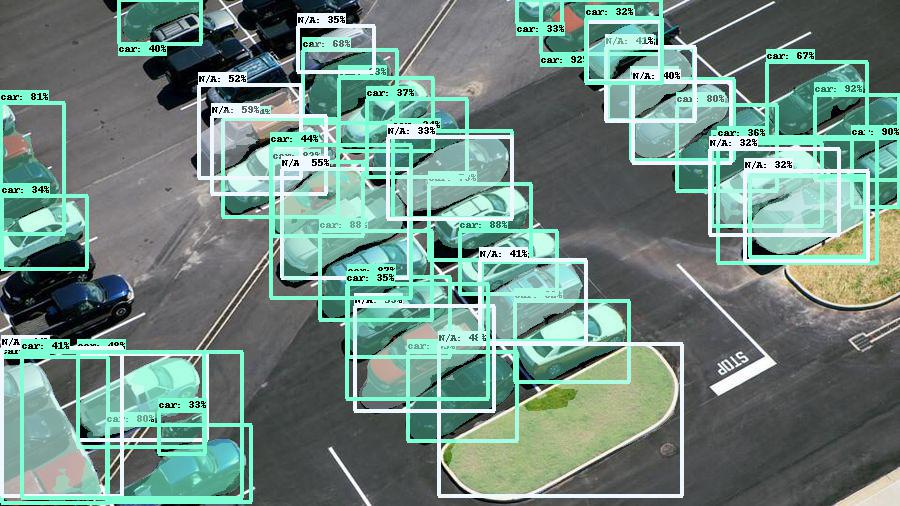

In [206]:
max_boxes_to_draw = 50   #@param {type:"integer"}
min_score_thresh = 0.1    #@param {type:"slider", min:0, max:1, step:0.01}

image_with_detections = visualization_utils.visualize_boxes_and_labels_on_image_array(
    np_image,
    detection_boxes,
    detection_classes,
    detection_scores,
    category_index,
    instance_masks=segmentations,
    use_normalized_coordinates=False,
    max_boxes_to_draw=max_boxes_to_draw,
    min_score_thresh=min_score_thresh)
output_image_path = 'p1_result.jpg'
Image.fromarray(image_with_detections.astype(np.uint8)).save(output_image_path)
display.display(display.Image(output_image_path, width=1024))

# What's next

* Learn about [Cloud TPUs](https://cloud.google.com/tpu/docs) that Google designed and optimized specifically to speed up and scale up ML workloads for training and inference and to enable ML engineers and researchers to iterate more quickly.
* Explore the range of [Cloud TPU tutorials and Colabs](https://cloud.google.com/tpu/docs/tutorials) to find other examples that can be used when implementing your ML project.
* [Here's](https://cloud.google.com/tpu/docs/tutorials/mask-rcnn) a direct link to the Mask R-CNN tutorial.
